In [ ]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Reshape
from tensorflow.keras.utils import to_categorical
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.layers import Dropout, InputLayer, LSTM
from keras.layers import Bidirectional, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout, UpSampling1D, AveragePooling1D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Function to modify the dimensions of the x inputs from 6 dimensions to 24 dimensions so that we can have one-to-one mapping with the corresponding labels
Run the next 2 cells below to get the modified dataset in a variable called **frame**

In [ ]:
def prepare_data(imu, imu_t, ann, ann_t):
  train_x = pd.concat([imu, imu_t], axis=1)
  train_y = pd.concat([ann, ann_t], axis=1)
  pos_x = 0
  pos_y = 0
  train_x_transformed = pd.DataFrame(0.0,index=range(train_y.shape[0]),columns=range(25))
  while pos_y < train_y.shape[0]:
    temp_row = []
    while train_x.loc[pos_x,'x_time'] < train_y.loc[pos_y,'y_time']:
      temp_row = temp_row + list(train_x.loc[pos_x,['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']])
      pos_x += 1
    for i in range(len(temp_row)):
      train_x_transformed.at[pos_y,i] = temp_row[i]
    train_x_transformed.at[pos_y,24] = train_y.loc[pos_y,'class']
    pos_y +=1
  return train_x_transformed

In [ ]:
import glob
import pandas as pd

path = '/content/drive/MyDrive/ECE542_fa2021_Project_TerrainRecognition/TrainingData' # Change this as required
all_files = glob.glob(path + "/*__x.csv")

li = []

for filename in all_files:
  subject_id = filename[len(path):-7]
  print(subject_id)
  imu = pd.read_csv(path+subject_id+'__x.csv',names=['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z'])
  imu_t = pd.read_csv(path+subject_id+'__x_time.csv',names=['x_time'])
  ann = pd.read_csv(path+subject_id+'__y.csv',names=['class'])
  ann_t = pd.read_csv(path+subject_id+'__y_time.csv',names=['y_time'])
  li.append(prepare_data(imu, imu_t, ann, ann_t))

frame = pd.concat(li, axis=0, ignore_index=True)

/subject_001_01
/subject_001_06
/subject_001_05
/subject_001_03
/subject_001_08
/subject_001_07
/subject_001_04
/subject_002_03
/subject_002_01
/subject_002_05
/subject_002_04
/subject_002_02
/subject_001_02
/subject_003_01
/subject_003_03
/subject_003_02
/subject_004_01
/subject_004_02
/subject_005_02
/subject_005_01
/subject_005_03
/subject_006_01
/subject_006_02
/subject_006_03
/subject_007_01
/subject_007_02
/subject_007_03
/subject_007_04
/subject_008_01


In [ ]:
print(frame.shape)

(335413, 25)


Normalizing the data using StandardScalar()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
frame.loc[:,frame.columns != 24] = scaler.fit_transform(frame.loc[:,frame.columns != 24])

In [ ]:
df_x = frame.loc[:,frame.columns != 24]
df_y = frame.loc[:,frame.columns == 24]

Dividing the Training dataset into train and test dataset

In [ ]:
df = frame.sample(frac=1).reset_index(drop=True)

# sampling number for each class
n1 = 2000
n2 = 2000
n3 = 2000
n4 = 2000


# 1. get indexes and lengths for the classes respectively
idx1 = df.index.values[df[24] == 0.0]
idx2 = df.index.values[df[24] == 1.0]
idx3 = df.index.values[df[24] == 2.0]
idx4 = df.index.values[df[24] == 3.0]

len1 = len(idx1)  # 1000
len2 = len(idx2)  # 2500
len3 = len(idx3)  # 1000
len4 = len(idx4)  

# 2. draw index for test dataset
draw1 = np.random.permutation(len1)[:n1]  # keep the first n1 entries to be selected
idx1_test = idx1[draw1]
draw2 = np.random.permutation(len2)[:n2]
idx2_test = idx2[draw2]
draw3 = np.random.permutation(len3)[:n3]  # keep the first n1 entries to be selected
idx3_test = idx3[draw3]
draw4 = np.random.permutation(len4)[:n4]
idx4_test = idx4[draw4]
# combine the drawn indexes
idx_test = np.hstack([idx1_test, idx2_test,idx3_test, idx4_test])

# 3. derive index for train dataset
idx_train = df.index.difference(idx_test)

# split
df_train = df.loc[idx_train, :]  # optional: .reset_index(drop=True)
df_test = df.loc[idx_test, :]
# len(df_train) = 3300
# len(df_test) = 200    

# verify that no row was missing
idx_merged = np.hstack([df_train.index.values, df_test.index.values])


In [ ]:
df_x = df_train.loc[:,df_train.columns != 24]
df_y = df_train.loc[:,df_train.columns == 24]
df_x_val = df_test.loc[:,df_test.columns != 24]
df_y_val = df_test.loc[:,df_test.columns == 24]

Using ADASYN (Adaptive Synthetic Sampling) to solve the data imbalance problem in the dataset

In [ ]:
#Data Augmentation Technique
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state = 130)
df_x,df_y = ada.fit_resample(df_x,df_y)

Converting the labels into one-hot encoded values

In [ ]:
y_train_cat = to_categorical(df_y,4).reshape(-1,4)
df_y = pd.DataFrame(y_train_cat, columns = ['l1','l2','l3','l4'])
y_train_cat = to_categorical(df_y_val,4).reshape(-1,4)
df_y_val = pd.DataFrame(y_train_cat, columns = ['l1','l2','l3','l4'])

In [ ]:
df_x = pd.DataFrame(df_x)
print(df_x)

               0         1         2   ...        21        22        23
0       -0.564533 -0.029144 -0.897771  ... -0.882136 -0.975342 -0.318007
1       -0.738120  0.173095 -0.349059  ... -0.480346  0.320979  0.754475
2        0.100470  0.227963 -0.475916  ...  0.048960 -0.117261  0.103093
3       -0.666097  0.253110  0.450280  ... -0.186881 -1.254059 -0.721577
4       -0.318037 -0.482365  0.674363  ...  1.769598  1.702597  0.354914
...           ...       ...       ...  ...       ...       ...       ...
1000840 -0.237399 -0.079255 -0.417723  ... -0.333290 -0.410740  0.190100
1000841 -0.253996 -0.015870 -0.465646  ... -0.349621 -0.360833  0.173201
1000842 -0.240871 -0.062743 -0.430328  ... -0.263164 -0.402147  0.155830
1000843 -0.271232 -0.080264 -0.426674  ... -0.307032 -0.431901  0.152516
1000844 -0.256437 -0.024810 -0.461268  ... -0.343615 -0.370048  0.170574

[1000845 rows x 24 columns]


In [ ]:
print(df_y)

          l1   l2   l3   l4
0        1.0  0.0  0.0  0.0
1        1.0  0.0  0.0  0.0
2        1.0  0.0  0.0  0.0
3        1.0  0.0  0.0  0.0
4        0.0  0.0  0.0  1.0
...      ...  ...  ...  ...
1000840  0.0  0.0  0.0  1.0
1000841  0.0  0.0  0.0  1.0
1000842  0.0  0.0  0.0  1.0
1000843  0.0  0.0  0.0  1.0
1000844  0.0  0.0  0.0  1.0

[1000845 rows x 4 columns]


Function to convert the data into 3-D format for the model.

In [ ]:
def define_windows(df_x, df_y, windowsize=120):
  window_x=[]
  window_y=[]
  for i in range(0, len(df_x)-windowsize, windowsize+1):
    window_x.append([df_x.values[i:i+windowsize]])
    window_y.append([df_y.values[i:i+windowsize]])
    #window_y.append([df_y[['l1','l2','l3','l4']].values[i:i+windowsize]])
  print(len(window_x),np.array(window_x).shape,np.array(window_y).shape)
  window_x=np.array(window_x).reshape(-1,windowsize,24)
  window_y=np.array(window_y).reshape(-1,windowsize,4)

  return window_x, window_y

In [ ]:
wsize = 1
x_window, y_window = define_windows(df_x, df_y, wsize)
y = y_window.copy().reshape(-1,4)
print(x_window.shape, y_window.shape,y.shape)

500422 (500422, 1, 1, 24) (500422, 1, 1, 4)
(500422, 1, 24) (500422, 1, 4) (500422, 4)


In [ ]:
wsize = 1
x_window_val, y_window_val = define_windows(df_x_val, df_y_val, wsize)
y_val = y_window_val.copy().reshape(-1,4)
print(x_window_val.shape, y_window_val.shape,y_val.shape)

4000 (4000, 1, 1, 24) (4000, 1, 1, 4)
(4000, 1, 24) (4000, 1, 4) (4000, 4)


In [ ]:
# To plot the loss and accuracy curves for training and validation datasets
import matplotlib.pyplot as plt
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [ ]:

# Function for changing the categorical prediction to numerical prediction
def flatten_pred(y_pred):
  y_hat=[]
  for i in y_pred:
    for j in i:
      y_hat.append(np.argmax(j))
  
  return y_hat

Main Model

In [ ]:
def create_LSTM():
  model = Sequential()
  model.add(Bidirectional(LSTM(100,return_sequences=True, input_shape=(1,24))))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True, activation="relu"))
  model.add(Dropout(0.1))
  model.add(Dense(25, activation="relu"))
  model.add(Dense(4, activation="softmax"))
  model.compile(optimizer=Adam(learning_rate=0.01),  loss='categorical_crossentropy', metrics = ['accuracy'], sample_weight_mode="temporal")
  return model

In [ ]:
lstm_model = create_LSTM()

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

history_lstm = lstm_model.fit(x_window, y_window, epochs=50,batch_size=128, verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=(x_window_val, y_window_val))

Epoch 1/50
3910/3910 [==============================] - 54s 12ms/step - loss: 0.6643 - accuracy: 0.7029 - val_loss: 0.5351 - val_accuracy: 0.7582 - lr: 0.0100
Epoch 2/50
3910/3910 [==============================] - 47s 12ms/step - loss: 0.5446 - accuracy: 0.7607 - val_loss: 0.5090 - val_accuracy: 0.7822 - lr: 0.0100
Epoch 3/50
3910/3910 [==============================] - 44s 11ms/step - loss: 0.5152 - accuracy: 0.7754 - val_loss: 0.4884 - val_accuracy: 0.7952 - lr: 0.0100
Epoch 4/50
3910/3910 [==============================] - 43s 11ms/step - loss: 0.4977 - accuracy: 0.7832 - val_loss: 0.5002 - val_accuracy: 0.7885 - lr: 0.0100
Epoch 5/50
3910/3910 [==============================] - 45s 12ms/step - loss: 0.4860 - accuracy: 0.7890 - val_loss: 0.5025 - val_accuracy: 0.7945 - lr: 0.0100
Epoch 6/50
3910/3910 [==============================] - 45s 11ms/step - loss: 0.4764 - accuracy: 0.7936 - val_loss: 0.4982 - val_accuracy: 0.7918 - lr: 0.0100
Epoch 7/50
3910/3910 [========================

In [ ]:
#This is our final model
from sklearn.metrics import classification_report

y_val_pred = lstm_model.predict(x_window_val)
print(y_val_pred.shape)
y_val_pred_flat = flatten_pred(y_val_pred)
y_val_flat = flatten_pred(y_window_val)
print(len(y_val_pred_flat),len(y_val_flat))
print(classification_report(y_val_pred_flat, y_val_flat))

(4000, 1, 4)
4000 4000
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       940
           1       0.92      0.93      0.92       985
           2       0.95      0.93      0.94      1023
           3       0.74      0.70      0.72      1052

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



Plotting Loss and Accuracy curves on train and validation dataset

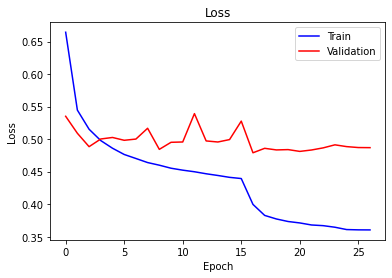

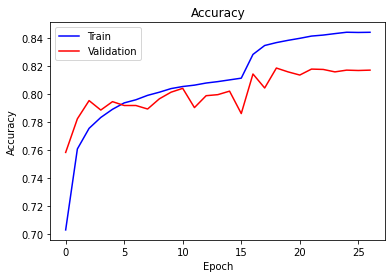

In [ ]:
plot_history(history_lstm)

Displaying the Confusion Matrix

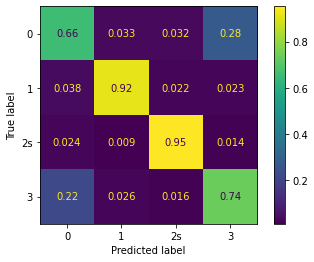

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val_flat,y_val_pred_flat,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0','1','2','3'])
disp.plot()

Generating Predictions for the Unknown test data set

In [ ]:

# Defining Function to Create window for test dataset
def define_test_windows(df_x, windowsize=40):
  window_x=[]
  for i in range(0, len(df_x)-windowsize, windowsize):
    window_x.append([df_x.values[i:i+windowsize]])
  window_x=np.array(window_x).reshape(-1,windowsize,24)
  
  return window_x

In [ ]:
def predict_testdata(imu, imu_t, ann_t):
  train_x = pd.concat([imu, imu_t], axis=1)
  train_y = pd.concat([ann_t], axis=1)
  pos_x = 0
  pos_y = 0
  train_x_transformed = pd.DataFrame(0.0,index=range(train_y.shape[0]),columns=range(24))
  label_y = []
  while pos_y < train_y.shape[0]:
    temp_row = []
    while train_x.loc[pos_x,'x_time'] < train_y.loc[pos_y,'y_time']:
      temp_row = temp_row + list(train_x.loc[pos_x,['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']])
      pos_x += 1
    for i in range(len(temp_row)):
      train_x_transformed.at[pos_y,i] = temp_row[i]
    pos_y +=1
  scaler = StandardScaler()
  df_x = scaler.fit_transform(train_x_transformed)
  df_x = pd.DataFrame(df_x)
  df_x = define_test_windows(df_x, 1)
  y_pred = lstm_model.predict(df_x)
  y_pred = y_pred.tolist()
  y_pred = flatten_pred(y_pred)
  for i in range(train_y.shape[0]-len(y_pred)):
    y_pred.append(0)
  print(len(y_pred))
  print(train_y.shape)
  label_df = pd.DataFrame(y_pred, columns = None)
  return label_df


In [ ]:
t_path = '/content/drive/MyDrive/ECE542_fa2021_Project_TerrainRecognition/TestData/' # Change this as required
all_files = glob.glob(t_path + "/*__x.csv")

for filename in all_files:
  subject_id = filename[len(t_path):-7]
  print(subject_id)
  imu = pd.read_csv(t_path+subject_id+'__x.csv',names=['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z'])
  imu_t = pd.read_csv(t_path+subject_id+'__x_time.csv',names=['x_time'])
  # ann = pd.read_csv(path+subject_id+'__y.csv',names=['class'])
  ann_t = pd.read_csv(t_path+subject_id+'__y_time.csv',names=['y_time'])
  ann = predict_testdata(imu, imu_t, ann_t)
  ann.to_csv('/content/drive/MyDrive/Team_14_Final_preds_C3/'+subject_id+'__y.csv',index=False, header=None, index_label=False)

subject_012_01
11330
(11330, 1)
subject_011_01
12940
(12940, 1)
subject_010_01
12270
(12270, 1)
subject_009_01
9498
(9498, 1)


Plotting one of the Test prediction values

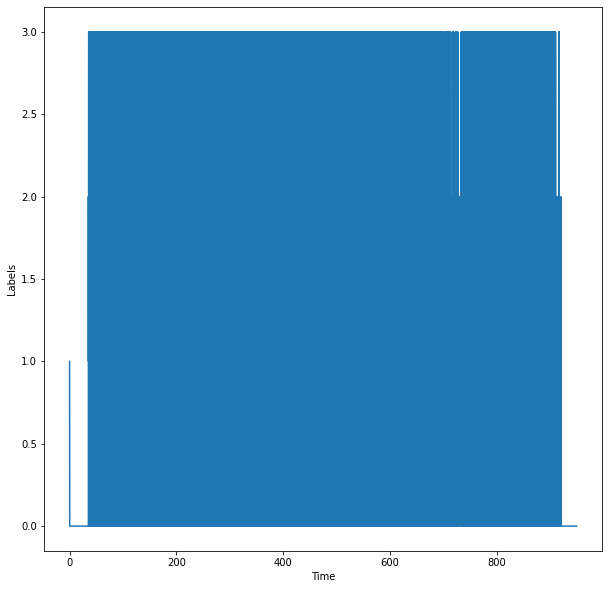

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
y_time = pd.read_csv('/content/drive/MyDrive/ECE542_fa2021_Project_TerrainRecognition/TestData/subject_009_01__y_time.csv',names=['y_time'])
y_values = pd.read_csv('/content/drive/MyDrive/Team_14_Final_preds_C3/subject_009_01__y.csv',names=['class'])
plt.plot(y_time, y_values)
plt.xlabel("Time")
plt.ylabel("Labels")
plt.savefig('the_best_plot.pdf')

In [ ]:
y_values.value_counts()

class
3        3866
0        3636
1        1527
2         469
dtype: int64